# Assignment 8: Stock Price Prediction using RNN
## Name: Semanti Ghosh
## Roll No.: 22IM10036

### Importing all the necessary libraries

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime, timedelta

### Dataset Selection and Preprocessing

For this assignment, **TCS.NS** data has been chosen from **NIFTY-50 (from Yahoo Finance)**. The training set starts 5 years prior to the current date and ends 3 months prior to the current date. The test data starts 3 months prior to the current date and ends on the current date.

In [4]:
# Set the current date
current_date = datetime.today().strftime('%Y-%m-%d')

# Define the training and testing periods
start_date = (datetime.today() - timedelta(days=5*365)).strftime('%Y-%m-%d')  # 5 years back
train_end_date = (datetime.today() - timedelta(days=90)).strftime('%Y-%m-%d')  # 3 months back
test_start_date = train_end_date  # Test starts from 3 months back

# Download stock data from Yahoo Finance
tcs_data = yf.download('TCS.NS', start=start_date, end=current_date)

# Splitting the dataset into training and testing sets
train_data = tcs_data.loc[start_date:train_end_date]
test_data = tcs_data.loc[test_start_date:current_date]

# Print dataset sizes
print(f"Train set size: {train_data.shape[0]} rows, {train_data.shape[1]} columns")
print(f"Test set size: {test_data.shape[0]} rows, {test_data.shape[1]} columns")

# Separate input (X) and output (y)
X_train = train_data.drop(columns=['Close'])  # Keep all columns except 'Close'
y_train = train_data[['Close']]  # Target variable

X_test = test_data.drop(columns=['Close'])
y_test = test_data[['Close']]

# Normalize the input data (X) and output (y) separately
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert back to DataFrame for better handling
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index, columns=['Close'])
y_test_scaled = pd.DataFrame(y_test_scaled, index=y_test.index, columns=['Close'])

# Print first few rows of preprocessed data
print("Train set (X) preview:")
print(X_train_scaled.head())

print("\nTrain set (y) preview:")
print(y_train_scaled.head())

print("\nTest set (X) preview:")
print(X_test_scaled.head())

print("\nTest set (y) preview:")
print(y_test_scaled.head())


[*********************100%***********************]  1 of 1 completed

Train set size: 1175 rows, 5 columns
Test set size: 62 rows, 5 columns
Train set (X) preview:
Price           High       Low      Open    Volume
Ticker        TCS.NS    TCS.NS    TCS.NS    TCS.NS
Date                                              
2020-04-03  0.000000  0.000000  0.009243  0.283497
2020-04-07  0.014156  0.016966  0.000015  0.267860
2020-04-08  0.020378  0.015732  0.015394  0.311450
2020-04-09  0.011980  0.025047  0.012457  0.261755
2020-04-13  0.014511  0.029613  0.015702  0.144050

Train set (y) preview:
               Close
Date                
2020-04-03  0.000000
2020-04-07  0.036857
2020-04-08  0.015611
2020-04-09  0.034101
2020-04-13  0.031999

Test set (X) preview:
Price           High       Low      Open    Volume
Ticker        TCS.NS    TCS.NS    TCS.NS    TCS.NS
Date                                              
2025-01-01  0.849980  0.860680  0.842735  0.030901
2025-01-02  0.866422  0.864536  0.851292  0.079552
2025-01-03  0.865399  0.862977  0.871332  0.08316

### Training the RNN Model

In [5]:
# Convert data into sequences for LSTM
def create_sequences(X, y, n_timestep):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_timestep):
        X_seq.append(X[i:i + n_timestep])
        y_seq.append(y[i + n_timestep])
    return np.array(X_seq), np.array(y_seq)

# Convert train and test data into sequences
n_timestep = 60  # Using past 60 days
X_train_seq, y_train_seq = create_sequences(X_train_scaled.values, y_train_scaled.values, n_timestep)
X_test_seq, y_test_seq = create_sequences(X_test_scaled.values, y_test_scaled.values, n_timestep)

# Convert to PyTorch tensors
X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32)

# Create PyTorch Dataset
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train_seq, y_train_seq)
test_dataset = StockDataset(X_test_seq, y_test_seq)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=50, num_layers=3, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)  # Predict closing price

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Use last LSTM output

# Initialize Model
input_dim = X_train_seq.shape[2]  # Number of features
model = LSTMModel(input_dim=input_dim)

# Loss function & optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

print("Training complete!")



Epoch 1/50, Loss: 0.097378
Epoch 2/50, Loss: 0.017759
Epoch 3/50, Loss: 0.003272
Epoch 4/50, Loss: 0.002213
Epoch 5/50, Loss: 0.002437
Epoch 6/50, Loss: 0.001942
Epoch 7/50, Loss: 0.001746
Epoch 8/50, Loss: 0.001613
Epoch 9/50, Loss: 0.001603
Epoch 10/50, Loss: 0.001612
Epoch 11/50, Loss: 0.001515
Epoch 12/50, Loss: 0.001738
Epoch 13/50, Loss: 0.001570
Epoch 14/50, Loss: 0.001356
Epoch 15/50, Loss: 0.001353
Epoch 16/50, Loss: 0.001506
Epoch 17/50, Loss: 0.001299
Epoch 18/50, Loss: 0.001359
Epoch 19/50, Loss: 0.001513
Epoch 20/50, Loss: 0.001173
Epoch 21/50, Loss: 0.001164
Epoch 22/50, Loss: 0.001216
Epoch 23/50, Loss: 0.001256
Epoch 24/50, Loss: 0.001145
Epoch 25/50, Loss: 0.001221
Epoch 26/50, Loss: 0.001028
Epoch 27/50, Loss: 0.001095
Epoch 28/50, Loss: 0.001248
Epoch 29/50, Loss: 0.001027
Epoch 30/50, Loss: 0.001060
Epoch 31/50, Loss: 0.001073
Epoch 32/50, Loss: 0.001032
Epoch 33/50, Loss: 0.001000
Epoch 34/50, Loss: 0.001092
Epoch 35/50, Loss: 0.000989
Epoch 36/50, Loss: 0.001077
E

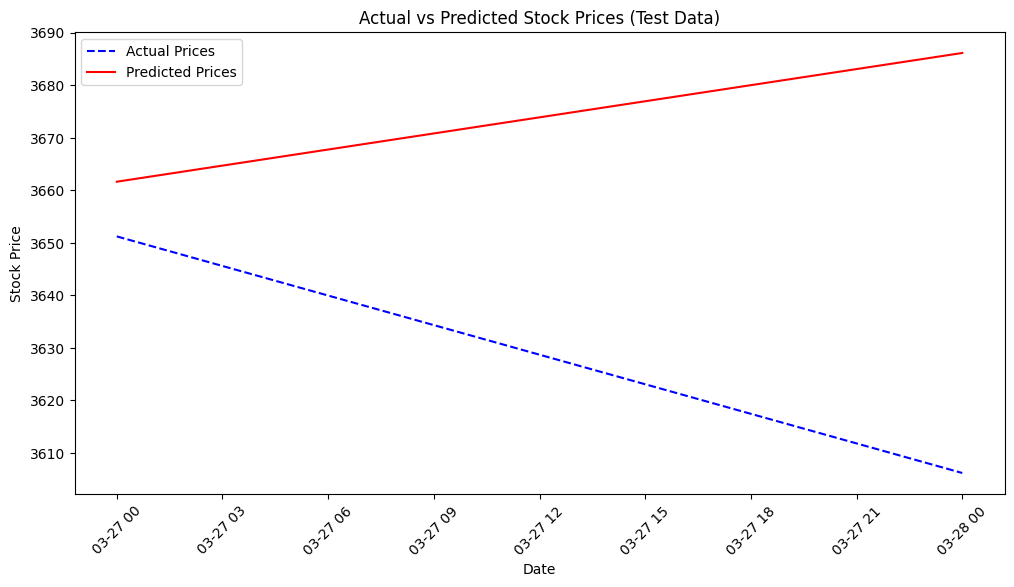

In [7]:
# Use real dates for the x-axis
test_dates = test_data.index[n_timestep:]  # Align dates with predictions

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label="Actual Prices", color='blue', linestyle='dashed')
plt.plot(test_dates, y_pred_actual, label="Predicted Prices", color='red')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (Test Data)")
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.show()

In [12]:
# Ensure necessary imports
from sklearn.metrics import mean_squared_error

# Create sequence function
def create_sequences(input_data, output_data, n_timestep):
    X = []
    y = []
    for i in range(n_timestep, len(input_data)):
        X.append(input_data[i-n_timestep:i])
        y.append(output_data[i])
    return np.array(X), np.array(y)

# Define the dataset class
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define hyperparameter grid
param_grid = {
    'n_drop': [0.1, 0.2, 0.3],
    'n_timestep': [30, 60, 90],
    'batch_size': [16, 32, 64]
}

# Function to perform the grid search
def grid_search(param_grid):
    best_mse = float('inf')
    best_params = {}
    
    for n_drop in param_grid['n_drop']:
        for n_timestep in param_grid['n_timestep']:
            for batch_size in param_grid['batch_size']:
                print(f"Training with n_drop={n_drop}, n_timestep={n_timestep}, batch_size={batch_size}")
                
                # Prepare the data using the current n_timestep
                X_train_seq, y_train_seq = create_sequences(X_train_scaled.values, y_train_scaled.values, n_timestep)
                X_test_seq, y_test_seq = create_sequences(X_test_scaled.values, y_test_scaled.values, n_timestep)
                
                # Convert to PyTorch tensors
                X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
                y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32)
                X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
                y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32)
                
                # Create DataLoader for current batch_size
                train_dataset = StockDataset(X_train_seq, y_train_seq)
                test_dataset = StockDataset(X_test_seq, y_test_seq)
                
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                
                # Initialize the model
                model = LSTMModel(input_dim=X_train_seq.shape[2], hidden_dim=50, num_layers=3, dropout=n_drop)
                
                # Loss function & optimizer
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                
                # Training Loop (simplified for grid search)
                for epoch in range(5):  # Limiting epochs for faster grid search (adjust as needed)
                    model.train()
                    epoch_loss = 0
                    for X_batch, y_batch in train_loader:
                        optimizer.zero_grad()
                        y_pred = model(X_batch)
                        loss = criterion(y_pred, y_batch)
                        loss.backward()
                        optimizer.step()
                        epoch_loss += loss.item()
                
                # Evaluate the model on test data
                model.eval()
                y_pred_list = []
                
                with torch.no_grad():
                    for X_batch, _ in test_loader:
                        y_pred = model(X_batch)
                        y_pred_list.append(y_pred.numpy())
                
                # Flatten predictions
                y_pred_list = np.array(y_pred_list).reshape(-1, 1)  # Column vector (N,1)
                y_pred_actual = scaler_y.inverse_transform(y_pred_list.reshape(-1, 1))
                y_test_actual = scaler_y.inverse_transform(y_test_seq.numpy().reshape(-1, 1))
                
                # Calculate MSE
                mse = mean_squared_error(y_test_actual, y_pred_actual)
                print(f"Test MSE: {mse:.6f}")
                
                # Track the best model
                if mse < best_mse:
                    best_mse = mse
                    best_params = {'n_drop': n_drop, 'n_timestep': n_timestep, 'batch_size': batch_size}
    
    return best_params, best_mse

# Run grid search
best_params, best_mse = grid_search(param_grid)

# Output best hyperparameters and corresponding MSE
print("\nBest Hyperparameters:", best_params)
print("Best MSE:", best_mse)


Training with n_drop=0.1, n_timestep=30, batch_size=16
Test MSE: 39654.394531
Training with n_drop=0.1, n_timestep=30, batch_size=32
Test MSE: 36866.832031
Training with n_drop=0.1, n_timestep=30, batch_size=64
Test MSE: 58098.953125
Training with n_drop=0.1, n_timestep=60, batch_size=16
Test MSE: 2855.279785
Training with n_drop=0.1, n_timestep=60, batch_size=32
Test MSE: 637.479370
Training with n_drop=0.1, n_timestep=60, batch_size=64
Test MSE: 1275.758179
Training with n_drop=0.1, n_timestep=90, batch_size=16


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.